In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.make_holidays import make_holidays_df

In [2]:
# Load the dataset
df = pd.read_csv('../data/preprocessed/df_agg_area.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1097 non-null   object
 1   vacancies    1097 non-null   int64 
 2   area_BROCK   1097 non-null   int64 
 3   area_EXCH    1097 non-null   int64 
 4   area_FRASER  1097 non-null   int64 
 5   area_GREEN   1097 non-null   int64 
 6   area_IONA    1097 non-null   int64 
 7   area_KWTQ    1097 non-null   int64 
 8   area_MARINE  1097 non-null   int64 
 9   area_POND    1097 non-null   int64 
 10  area_STJOHN  1097 non-null   int64 
 11  area_TBIRD   1097 non-null   int64 
 12  area_AP_UA   1097 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 111.5+ KB


In [4]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.rename(columns={'date': 'ds'}, inplace=True)
df

ds  vacancies  area_BROCK  area_EXCH  area_FRASER  area_GREEN  \
0    2021-11-01         74           1          5            2           7   
1    2021-11-02         91           2          5            2           7   
2    2021-11-03         93           2          5            2           7   
3    2021-11-04         95           2          5            2           7   
4    2021-11-05         93           2          5            2           7   
...         ...        ...         ...        ...          ...         ...   
1092 2024-10-28         36           3          0            0           1   
1093 2024-10-29         34           2          0            0           1   
1094 2024-10-30         34           2          0            0           1   
1095 2024-10-31         34           2          0            0           1   
1096 2024-11-01         32           2          0            1           1   

      area_IONA  area_KWTQ  area_MARINE  area_POND  area_STJOHN  area_TBIRD  \
0             0          0           23          6            2          11   
1             0          0           25          7            5          12   
2             0          0           25          7            4          13   
3             0          0           26          7            5          13   
4             0          0           26          7            5          12   
...         ...        ...          ...        ...          ...         ...   
1092          0          1           12          2            4           5   
1093          0          1           12          2            4           5   
1094          0          1           12          3            4           4   
1095          0          1           12          3            4           4   
1096          0          1           12          3            4           3   

      area_AP_UA  
0             17  
1             26  
2             28  
3             28  
4             27  
...          ...  
1092           8  
1093           7  
1094           7  
1095           7  
1096           5  

[1097 rows x 13 columns]

In [6]:
# Melt the dataframe to convert from wide to long format
df_long = df.melt(id_vars=['ds'], var_name='area', value_name='y')

# Preview the melted data
print(df_long.head())

          ds       area   y
0 2021-11-01  vacancies  74
1 2021-11-02  vacancies  91
2 2021-11-03  vacancies  93
3 2021-11-04  vacancies  95
4 2021-11-05  vacancies  93


In [7]:
area ='area_TBIRD'

# Extract year and month to group by month
df['year_month'] = df['ds'].dt.to_period('M')

# Find the date with the maximum vacancies for each month
idx = df.groupby('year_month')[area].idxmax()

# Retrieve the rows with the maximum vacancies
max_vacancy_per_month = df.loc[idx, ['ds', 'year_month', area]].reset_index(drop=True)

# Rename columns for clarity
max_vacancy_per_month.rename(columns={'ds': 'Date', 'year_month': 'Month', area: 'Max TBird Vacancies'}, inplace=True)

# Display the result
print(max_vacancy_per_month)

         Date    Month  Max TBird Vacancies
0  2021-11-30  2021-11                   14
1  2021-12-22  2021-12                   22
2  2022-01-02  2022-01                   24
3  2022-02-02  2022-02                   19
4  2022-03-29  2022-03                   18
5  2022-04-12  2022-04                   35
6  2022-05-03  2022-05                  106
7  2022-06-13  2022-06                   20
8  2022-07-13  2022-07                   14
9  2022-08-08  2022-08                   24
10 2022-09-03  2022-09                   12
11 2022-10-02  2022-10                    5
12 2022-11-05  2022-11                    7
13 2022-12-31  2022-12                    7
14 2023-01-02  2023-01                   16
15 2023-02-20  2023-02                   14
16 2023-03-30  2023-03                    9
17 2023-04-30  2023-04                   15
18 2023-05-05  2023-05                   85
19 2023-06-16  2023-06                   30
20 2023-07-02  2023-07                   19
21 2023-08-29  2023-08          

In [8]:
# Define holidays
holidays = pd.DataFrame({
  'holiday': 'move_out',
  'ds': pd.to_datetime(['2022-05-03', '2023-05-05', '2024-05-04']),  # move-out dates
    'lower_window': [-3, -5, -4],
    'upper_window': [2, 0, 0]
})

20:38:32 - cmdstanpy - INFO - Chain [1] start processing
20:38:32 - cmdstanpy - INFO - Chain [1] done processing


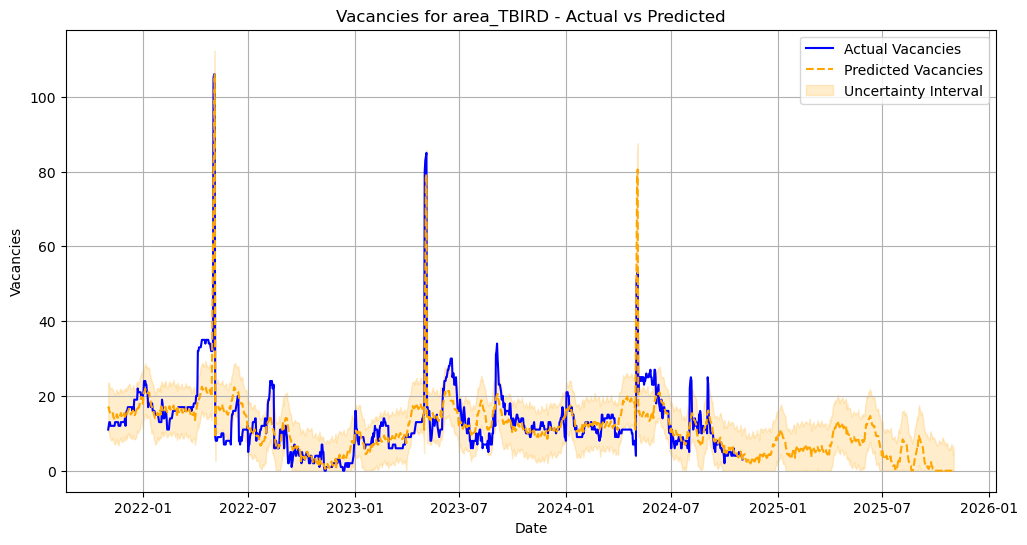

  0%|          | 0/2 [00:00<?, ?it/s]

20:38:35 - cmdstanpy - INFO - Chain [1] start processing
20:38:35 - cmdstanpy - INFO - Chain [1] done processing
20:38:35 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing


   horizon         mse       rmse        mae      mape     mdape     smape  \
0   9 days   14.587826   3.819401   2.489130  0.155032  0.119511  0.160680   
1  10 days    8.081641   2.842823   1.984715  0.142101  0.119511  0.138461   
2  11 days    3.781066   1.944496   1.703813  0.140106  0.126806  0.132222   
3  12 days    4.394122   2.096216   1.876579  0.156667  0.145623  0.149365   
4  13 days    6.155100   2.480947   2.229893  0.189928  0.172825  0.184016   
..     ...         ...        ...        ...       ...       ...       ...   
77 86 days  289.132327  17.003892  10.737070  1.749280  0.973068  0.625120   
78 87 days  278.949000  16.701766  10.280604  1.663049  0.442912  0.575825   
79 88 days  375.446621  19.376445  11.818991  1.611299  0.363974  0.552941   
80 89 days  468.506343  21.645007  13.289915  1.548235  0.227859  0.522463   
81 90 days  450.208800  21.218124  12.491656  1.426547  0.218416  0.480864   

    coverage  
0   0.888889  
1   0.944444  
2   1.000000  
3  

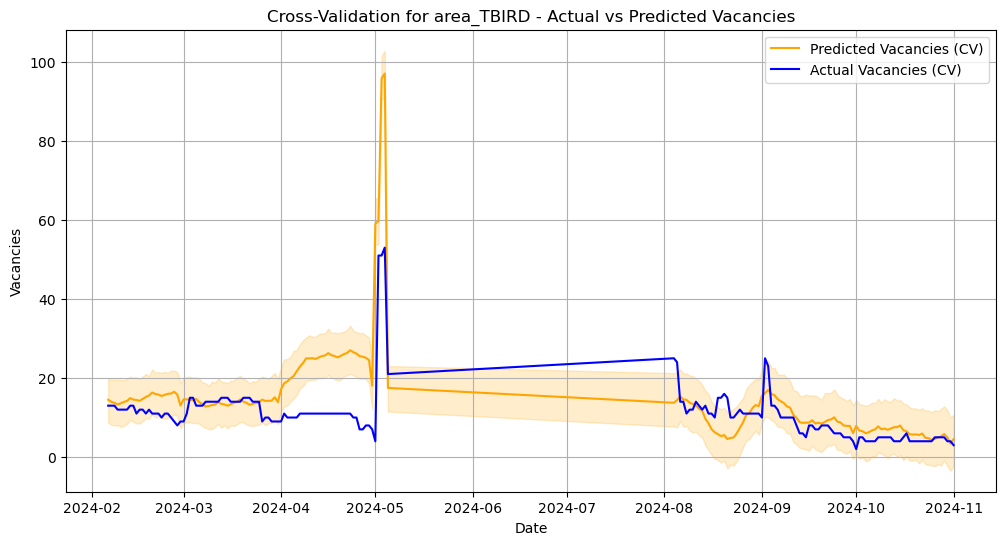

In [16]:
# Load your dataset for a single area
area = 'area_TBIRD'  # Replace with your area column name
df_tbird = df[['ds', area]].rename(columns={area: 'y'})
df_tbird['end_of_month'] = df_tbird['ds'].dt.is_month_end.astype(int)
# Initialize Prophet model
model = Prophet(holidays=holidays, 
                yearly_seasonality=20,
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=15,
                seasonality_mode='additive')

# Add 'is_end_of_month' as a regressor
model.add_regressor('end_of_month')

# Fit the model
model.fit(df_tbird)

# Predict on future (1 year ahead)
future = model.make_future_dataframe(periods=365)

# Add the 'end_of_month' column to the future DataFrame
future['end_of_month'] = future['ds'].dt.is_month_end.astype(int)

forecast = model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot the forecast with actual values
plt.figure(figsize=(12, 6))
plt.plot(df_tbird['ds'], df_tbird['y'], label="Actual Vacancies", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Vacancies", color='orange', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label="Uncertainty Interval")
plt.title(f"Vacancies for {area} - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/forecasted_tbird.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-validation:
# Set up cross-validation for Prophet
cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')

# Performance Metrics:
# Evaluate the performance of the model on the cross-validation results
metrics = performance_metrics(cv_results)
print(metrics)

# Plot Cross-Validation Results:
plt.figure(figsize=(12, 6))
plt.plot(cv_results['ds'], cv_results['yhat'], label="Predicted Vacancies (CV)", color='orange')
plt.plot(cv_results['ds'], cv_results['y'], label="Actual Vacancies (CV)", color='blue')
plt.fill_between(cv_results['ds'], cv_results['yhat_lower'], cv_results['yhat_upper'], color='orange', alpha=0.2)
plt.title(f"Cross-Validation for {area} - Actual vs Predicted Vacancies")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Check the coefficients of the regressor
print(model.params['beta'])

[[ 2.14470e-02 -3.01119e-02 -4.25368e-03  3.24680e-03  7.53058e-03
   1.68256e-02 -4.81066e-03  2.81639e-03  8.85444e-03 -3.09980e-04
  -1.11048e-02  3.80400e-03  5.24876e-03  1.16297e-02  1.29413e-03
  -4.89860e-03  4.21453e-03  4.71233e-03 -1.06219e-03  5.16504e-03
  -4.18048e-03 -2.86794e-03  5.41426e-04 -3.29580e-04  1.22282e-03
   1.78682e-03  6.07615e-01  8.21662e-01 -8.94294e-02  5.92672e-01
   3.59606e-01  1.99580e-01 -5.32705e-02 -2.55547e-03 -1.42373e-02]]


In [12]:
forecast.to_csv('../data/predictions/forecast_tbird.csv', index = False)
df_tbird.to_csv('../data/predictions/df_tbird.csv', index = False)